<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 32821546.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
train_loader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

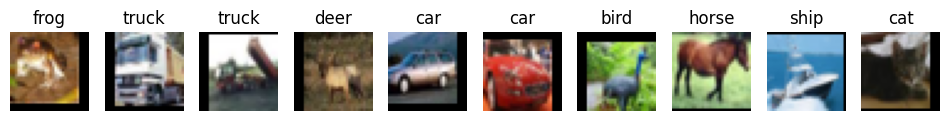

In [8]:

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()


In [9]:
#Creating a class that instantiate a CNN module:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels = 64, kernel_size =3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels = 128, kernel_size =3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels = 256, kernel_size =3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,  padding =1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding =0)
    self.fc1 = nn.Linear(512*2*2, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)


  def forward(self, X):
    X = self.pool(F.relu(self.conv1(X)))
    X = self.pool(F.relu(self.conv2(X)))
    X = self.pool(F.relu(self.conv3(X)))
    X = self.pool(F.relu(self.conv4(X)))
    X = torch.flatten(X, 1)
    X = F.relu(self.fc1(X))
    X = self.dropout(X)
    X = F.relu(self.fc2(X))
    X = self.fc3(X)



    return F.log_softmax(X, dim=1)





In [10]:
torch.manual_seed(42)
model = CNN()

In [11]:
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
#Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



In [19]:
import time

start_time = time.time()
#Create variables to track things

epochs = 20
train_losses =[]
test_losses = []
train_accuracies =[]
test_accuracies = []

for epoch in range(epochs):
  model.train()
  running_loss, correct, total =0.0,0,0
  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_losses.append(running_loss/len(train_loader))
  train_accuracies.append(100*correct/total)


  model.eval()
  running_loss, correct, total = 0.0,0,0
  with torch.no_grad():
    for images, labels in test_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss +=loss.item()
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (predicted ==labels).sum().item()
  test_losses.append(running_loss/len(test_loader))
  test_accuracies.append(100*correct/total)

  print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Test Acc: {test_accuracies[-1]:.2f}')


current_time = time.time()

total = current_time - start_time

print(f'Training Time: {total/60} Minutes')

Epoch [1/20], Train Loss: 0.4927, Test Loss: 0.5866, Train Acc: 83.37, Test Acc: 79.92
Epoch [2/20], Train Loss: 0.4964, Test Loss: 0.5372, Train Acc: 83.10, Test Acc: 81.72
Epoch [3/20], Train Loss: 0.4684, Test Loss: 0.5246, Train Acc: 84.17, Test Acc: 82.33
Epoch [4/20], Train Loss: 0.4530, Test Loss: 0.5449, Train Acc: 84.56, Test Acc: 81.57
Epoch [5/20], Train Loss: 0.4470, Test Loss: 0.5176, Train Acc: 84.84, Test Acc: 82.67
Epoch [6/20], Train Loss: 0.4328, Test Loss: 0.5365, Train Acc: 85.37, Test Acc: 82.73
Epoch [7/20], Train Loss: 0.4145, Test Loss: 0.5028, Train Acc: 85.94, Test Acc: 83.43
Epoch [8/20], Train Loss: 0.4102, Test Loss: 0.5077, Train Acc: 86.16, Test Acc: 83.04
Epoch [9/20], Train Loss: 0.3916, Test Loss: 0.5101, Train Acc: 86.96, Test Acc: 83.29
Epoch [10/20], Train Loss: 0.3876, Test Loss: 0.4716, Train Acc: 86.72, Test Acc: 84.34
Epoch [11/20], Train Loss: 0.3769, Test Loss: 0.5096, Train Acc: 87.32, Test Acc: 83.12
Epoch [12/20], Train Loss: 0.3772, Test L

In [27]:
#Batch 64
#epochs = 20, lr =0.001 came around 81% accuracy.
#epochs = 50, lr=0.001 came around   accuracy.
#epcochs = 20, lr=0.0001 came around 75.93% accuracy.
#epochs =20, lr =0.0005 came around 81.53% accuracy.
#epochs =20, lr =0.0005 came around 81.01% accuracy with dropout 0.5

#Batch 128

#epochs =20, lr =0.0005 came around 80.22% accuracy.
#epochs =20, lr =0.0001 came around 80.79% accuracy.

#Added 4th conv layer to see if this will increase the accuracy.
# batch_size =128
#epochs =20, lr =0.0001 came around 81.92% accuracy.

# batch_size =64
#epochs =20, lr =0.0001 came around 81.84% accuracy.

# batch_size =64 and adding dropout rate 0.5
#epochs =20, lr =0.0001 came around 81.84% accuracy.

#Used SGD with momentum and Got the better Accuracy ~ 83.51% with learning_rate =0.01- However, using this caused a noise between training and test - loss and accuracy
#Used SGD with momentum and Got the better Accuracy ~ 86% with learning_rate =0.001 - However, using this caused a noise between training and test - loss and accuracy